In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 0\. Convolution의 주요 특징

1. 가중치 공유: 같은 필터가 전체 이미지에 걸쳐 재사용됨.
2. 지역적 연결성: 각 출력 픽셀은 입력의 작은 영역(receptive field)만을 반영.
3. translation invariant: 입력에서 패턴의 위치가 바뀌어도 감지할 수 있음

# 1\. 간단한 Conv2D 레이어 생성


## 1-1\. Convolution 레이어 (`nn.Conv2d` 생성자 파라미터)

* `in_channels` : 입력 채널 수 (RGB는 3, grayscale은 1)
* `out_channels`: 출력 채널 수 (사용할 kernel의 개수)
* `kernel_size` : 필터 kernel의 크기 (3x3, 5x5 등)
* `stride`      : 필터가 이동하는 간격
* `padding`.    : 입력 주변에 추가할 픽셀 수

In [2]:
# Conv2D 파라미터 설정
in_channels = 1    # 입력 채널 수 (흑백 이미지), 다른 분야는 컬러 이미지를 선호
# 생각보다 의료쪽은 흑백 이미지만 쓰임. (단, 대장내시경 같은 곳에선 컬러 쓰는듯)
out_channels = 2   # 출력 채널 수 (필터 개수)
kernel_size = 3    # 커널 크기 (3x3)
stride = 1         # 스트라이드
padding = 1        # 패딩

In [3]:
# Conv2D 모듈 객체 생성
conv_layer = nn.Conv2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding
)

In [4]:
print(f"Conv2D 레이어 정보:")
print(f"- 입력 채널: {in_channels}")
print(f"- 출력 채널: {out_channels}")
print(f"- 커널 크기: {kernel_size}x{kernel_size}")
print(f"- 스트라이드: {stride}")
print(f"- 패딩:     {padding}")
print()

Conv2D 레이어 정보:
- 입력 채널: 1
- 출력 채널: 2
- 커널 크기: 3x3
- 스트라이드: 1
- 패딩:     1



# 2\. 입력 데이터 생성 (batch size, C, H, W)

`(batch_size, channels, height, width)` 형태의 4D 텐서

In [5]:
batch_size = 1
height, width = 5, 5
input_tensor = torch.randn(batch_size, in_channels, height, width)

print(f"입력 텐서 크기: {input_tensor.shape}")
print("입력 데이터:")
print(input_tensor.squeeze().numpy().round(2))
print()

입력 텐서 크기: torch.Size([1, 1, 5, 5])
입력 데이터:
[[-0.17  0.24  0.79 -0.29  0.92]
 [ 0.12  0.83  0.91 -1.21 -0.18]
 [ 0.07  2.29  1.16 -1.72 -0.79]
 [ 0.62 -0.62  0.18  0.59 -0.24]
 [ 1.19  0.84 -1.13  1.11 -0.61]]



# 3\. Convolution 연산 실행

1. 패딩 적용: 지정된 패딩만큼 입력 주변에 0을 추가
2. 커널 슬라이딩: 각 위치에서 필터와 입력의 element-wise 곱셈 후 합산
3. 편향 추가: 각 출력 채널에 해당하는 bias 값 추가
4. 출력 생성: 각 필터마다 하나의 출력 채널 생성

In [6]:
with torch.no_grad():  # 그래디언트 계산 비활성화
    output = conv_layer(input_tensor)

print(f"출력 텐서 크기: {output.shape}")
print()

출력 텐서 크기: torch.Size([1, 2, 5, 5])



# 4\. 커널(가중치) 확인

In [7]:
print("학습된 커널(가중치):")
weights = conv_layer.weight.data
bias    = conv_layer.bias.data

for i in range(out_channels):
    print(f"\n필터 {i+1}:")
    print(f"가중치 (3x3 kernel):")
    print(weights[i, 0].numpy().round(3))
    print(f"편향(bias): {bias[i].item():.3f}")

학습된 커널(가중치):

필터 1:
가중치 (3x3 kernel):
[[ 0.11  -0.017  0.293]
 [-0.02   0.301 -0.087]
 [-0.256 -0.21  -0.062]]
편향(bias): 0.168

필터 2:
가중치 (3x3 kernel):
[[ 0.009  0.315 -0.011]
 [-0.256  0.023  0.041]
 [-0.022 -0.227  0.268]]
편향(bias): -0.253


그냥 랜덤하게 만들어진 것임.

# 5\. 각 출력 채널별 결과 확인

In [8]:
print("\n=== 출력 결과 ===")
for i in range(out_channels):
    print(f"\n출력 채널 {i+1}:")
    print(output[0, i].numpy().round(3))


=== 출력 결과 ===

출력 채널 1:
[[ 0.019 -0.088  0.096  0.016  0.796]
 [ 0.047 -0.028 -0.265  0.274  0.697]
 [ 0.138  0.979  0.428 -0.392 -0.267]
 [ 0.777 -0.147 -0.134  0.382 -0.249]
 [ 0.261  0.629 -0.184  0.518  0.032]]

출력 채널 2:
[[-0.051 -0.119 -0.857 -0.217 -0.091]
 [ 0.326 -0.37  -1.016 -0.463  0.557]
 [-0.433  0.259 -0.446 -1.198  0.145]
 [-0.308 -0.228  0.875 -1.21  -0.561]
 [ 0.013 -0.775 -0.402  0.228 -0.622]]


# 6\. 수동으로 검증

## 6-1\. 패딩된 입력 생성

In [9]:
padded_input = torch.nn.functional.pad(
    input_tensor, (1, 1, 1, 1),
    mode='constant',
    value=0
    )
print("패딩된 입력:")
print(padded_input.squeeze().numpy().round(2))

패딩된 입력:
[[ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.17  0.24  0.79 -0.29  0.92  0.  ]
 [ 0.    0.12  0.83  0.91 -1.21 -0.18  0.  ]
 [ 0.    0.07  2.29  1.16 -1.72 -0.79  0.  ]
 [ 0.    0.62 -0.62  0.18  0.59 -0.24  0.  ]
 [ 0.    1.19  0.84 -1.13  1.11 -0.61  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]


## 6-2\. 검증결과: 첫 번째 필터로 첫 번째 픽셀 위치에서 수동 계산

In [11]:
kernel = weights[0, 0]  # 첫 번째 필터
input_patch = padded_input[0, 0, 0:3, 0:3]  # 3x3 패치 추출

manual_result = torch.sum(kernel * input_patch) + bias[0]
print(f"\n수동 계산 결과: {manual_result.item():.3f}")
print(f"PyTorch 결과:   {output[0, 0, 0, 0].item():.3f}")
print(f"차이: {abs(manual_result - output[0, 0, 0, 0]).item():.6f}")


수동 계산 결과: 0.019
PyTorch 결과:   0.019
차이: 0.000000


# Example: Laplacian Filter for Edge Detection

## 간단한 패턴이 있는 입력 생성

In [12]:
w = 11
h = 11
p = 3

In [13]:
simple_input = torch.zeros(1, 1, h, w)
simple_input[0, 0, p:h-p, p:w-p] = 1.0  # 가운데 사각형

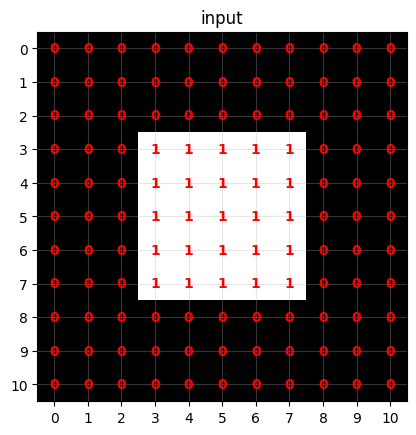

In [14]:
import matplotlib.pyplot as plt

plt.imshow(simple_input[0, 0].numpy(), cmap='gray')
plt.title('input')
plt.grid(True, alpha=0.3)
plt.xticks(range(w))
plt.yticks(range(h))

# 격자 위에 값 표시
for i in range(h):
    for j in range(w):
        plt.text(j, i, f'{simple_input[0,0,i,j].item():.0f}',
                 ha='center', va='center',
                 fontsize=10, fontweight='bold',
                 color='red')
plt.show()

## 2. 라플라스 필터 Conv2d 설정 (수동)

[Laplacian filter 에 대하여](https://dsaint31.me/mkdocs_site/DIP/cv2/ch02/dip_edge_detection_high_pass_filter/#laplacian-filter)

In [20]:
laplacian_conv = nn.Conv2d(1, 1, 3, padding=1, bias=False)
laplacian_kernel = torch.tensor([
    [[ 0,  1,  0],
     [ 1, -4,  1],
     [ 0,  1,  0]]
], dtype=torch.float32).unsqueeze(0)

laplacian_conv.weight.data = laplacian_kernel # 커널값 바꿀 수 있음 요 부분

+) 라플라시안 필터는 위에 0, 1, 0, 1, -4, 1, 0, 1, 0으로 됨

## 3. Convolution 연산 실행


In [21]:
with torch.no_grad():
    laplacian_output = laplacian_conv(simple_input)

laplacian_output.shape

torch.Size([1, 1, 11, 11])

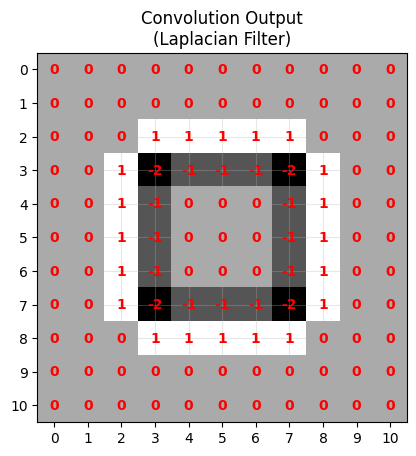

In [22]:
plt.imshow(laplacian_output[0, 0].numpy(), cmap='gray')
plt.title('Convolution Output\n(Laplacian Filter)')
plt.grid(True, alpha=0.3)
plt.xticks(range(w))
plt.yticks(range(h))

# 격자 위에 값 표시
for i in range(h):
    for j in range(w):
        plt.text(j, i, f'{laplacian_output[0,0,i,j].item():.0f}',
                 ha='center', va='center',
                 fontsize=10, fontweight='bold',
                 color='red')
plt.show()

## 4. Laplacian Filter Kernel

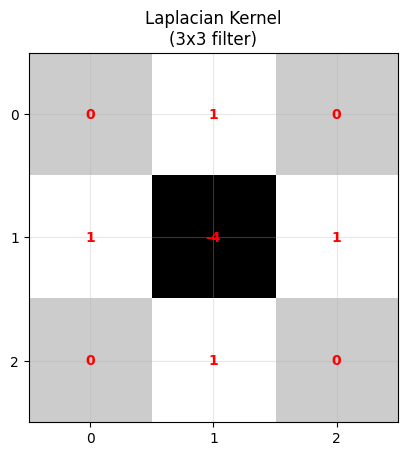

In [23]:
plt.imshow(laplacian_kernel[0, 0].numpy(), cmap='gray')
plt.title('Laplacian Kernel\n(3x3 filter)')
plt.grid(True, alpha=0.3)
plt.xticks(range(3))
plt.yticks(range(3))

# 격자 위에 값 표시
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{laplacian_kernel[0,0,i,j].item():.0f}',
                 ha='center', va='center',
                 fontsize=10, fontweight='bold',
                 color='red')
plt.show()

# Example: 다양한 Kernel 실행 결과.

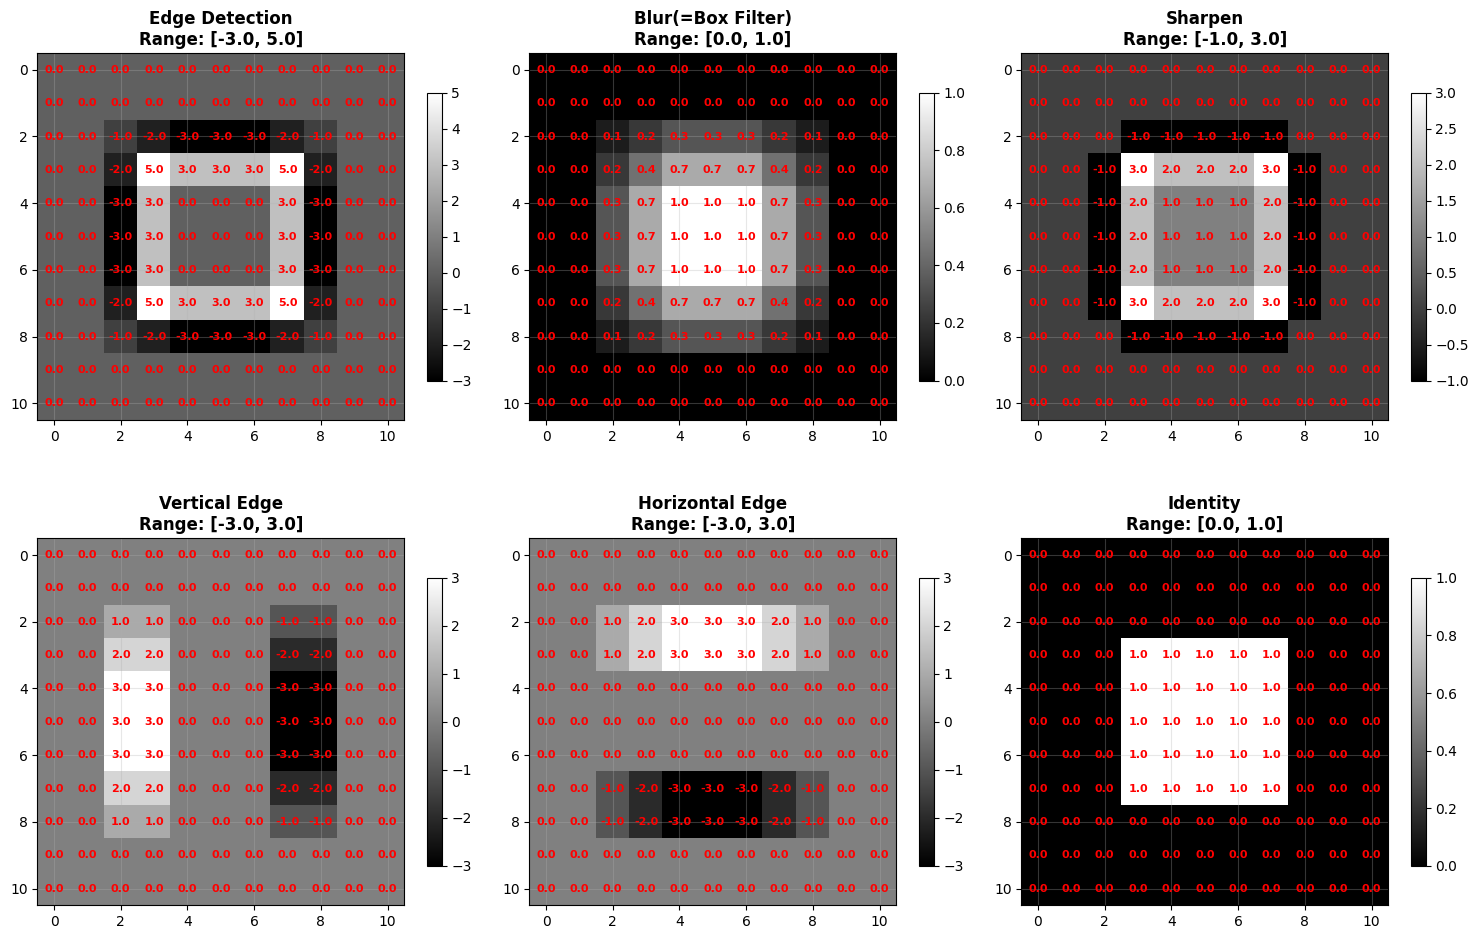

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 다양한 필터 정의
filters = {
    'Edge Detection'   : torch.tensor([[[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]]),
    'Blur(=Box Filter)': torch.tensor([[[1, 1, 1], [1, 1, 1], [1, 1, 1]]]) / 9,
    'Sharpen'          : torch.tensor([[[0, -1, 0], [-1, 5, -1], [0, -1, 0]]]),
    'Vertical Edge'    : torch.tensor([[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]]),
    'Horizontal Edge'  : torch.tensor([[[-1, -1, -1], [0, 0, 0], [1, 1, 1]]]),
    'Identity'         : torch.tensor([[[0, 0, 0], [0, 1, 0], [0, 0, 0]]])
}

for idx, (name, kernel) in enumerate(filters.items()):
    row = idx // 3
    col = idx % 3

    # Conv 레이어 생성 및 커널 설정
    conv = nn.Conv2d(1, 1, 3, padding=1, bias=False)
    conv.weight.data = kernel.unsqueeze(0).float()

    # 연산 실행
    with torch.no_grad():
        output = conv(simple_input)

    # 시각화
    output_np = output.squeeze().numpy()
    im = axes[row, col].imshow(output_np, cmap='gray')
    axes[row, col].set_title(f'{name}\nRange: [{output_np.min():.1f}, {output_np.max():.1f}]',
                            fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3)

    # 값 표시 (간단히)
    for i in range(0, h, 1):  # 격자를 건너뛰어 표시
        for j in range(0, w, 1):
            axes[row, col].text(j, i, f'{output_np[i,j]:.1f}',
                              ha='center', va='center', fontsize=8, fontweight='bold', color='red')

    plt.colorbar(im, ax=axes[row, col], shrink=0.6)

plt.tight_layout()
plt.show()